In [ ]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def build_dict(y_train, y_test):
    train_dict, test_dict = {}, {}
    
    for label in range(10):
      train_dict[label] = np.argwhere(label==y_train).reshape(-1)
      test_dict[label] = np.argwhere(label==y_test).reshape(-1)

    return train_dict, test_dict

def create_clients(x_train, y_train, x_test, y_test, num_clients):

    """
      Builds a list of Non-IID clients for the demo
        - Generates dictionaries of train and test dataset indices according to labels
        - Based on dictionaries, pick two random labels with replacement
        - Pick 100 random samples from the picked labels for train and test set
    """
    # Client Data Size
    client_size = x_train.shape[0] // num_clients
    shard_size = client_size // 2

    # Build Dictionaries
    train_dict, test_dict = build_dict(y_train, y_test)

    clients = []
    for i in range(num_clients):
        if (i % 20 == 0): print("Generating %d-th Clients ..." % (i+20))
        labels = np.random.choice(10, 2)

        train_ind = [np.random.choice(train_dict[l], shard_size) for l in labels]
        train_ind = [i for l in train_ind for i in l]
        train_inputs = tf.cast(tf.gather(x_train, train_ind), tf.float32)
        train_labels = tf.cast(tf.gather(y_train, train_ind), tf.uint8)

        test_ind = [np.random.choice(test_dict[l], shard_size) for l in labels]
        test_ind = [i for l in test_ind for i in l]
        test_inputs = tf.cast(tf.gather(x_test, test_ind), tf.float32)
        test_labels = tf.cast(tf.gather(y_test, test_ind), tf.uint8)

        clients.append(Client(train_inputs, train_labels, test_inputs, test_labels))
    
    return clients


In [ ]:
class Client(tf.keras.Model):

    def __init__(self, x_train, y_train, x_test, y_test):
        super(Client, self).__init__()
        
        # Inputs and Labels
        self.num_samples = x_train.shape[0]

        self.train_inputs, self.train_labels = x_train, y_train
        self.test_inputs, self.test_labels = x_test, y_test

        # Hyperparameters
        self.hidden_size = 200
        self.num_classes = 10
        self.num_epochs = 10
        self.batch_size = self.num_samples // 30

        # Initializer
        init = tf.keras.initializers.RandomNormal(stddev=0.1)

        # Layers (Need to be built prior to call)
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_size, activation='relu',
                                  kernel_initializer=init, bias_initializer=init),
            tf.keras.layers.Dense(self.num_classes, activation='softmax',
                                  kernel_initializer=init, bias_initializer=init)
        ])
        self.model.build((None, 784))

        # Optimizer
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

        # Loss
        self.loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

    def call(self, inputs):
        return self.model(inputs)

    def loss(self, logits, labels):
        l = self.loss_function(labels, logits)
        return tf.reduce_mean(l)

    def train(self, weights):
        self.model.set_weights(weights)
        for _ in range(self.num_epochs):
            shuffled = tf.random.shuffle(range(self.num_samples))
            inputs = tf.gather(self.train_inputs, shuffled)
            labels = tf.gather(self.train_labels, shuffled)
            for i in range(self.num_samples//self.batch_size):
                start, end = i*self.batch_size, (i+1)*self.batch_size

                with tf.GradientTape() as tape:
                    l = self.loss(self.call(inputs[start:end]), labels[start:end])
                
                g = tape.gradient(l, self.trainable_variables)
                self.optimizer.apply_gradients(zip(g, self.trainable_variables))

        return self.model.get_weights()

    def test(self):
        logits = self.call(self.test_inputs)
        preds = np.argmax(logits, axis=1)
        num_correct = np.sum(self.test_labels == preds)
        return num_correct

class Server:

    def __init__(self, clients):     
        # Clients
        self.clients = clients

        self.num_clients = len(clients)
        self.total_samples = sum(c.num_samples for c in self.clients)

        # Hyperparameters
        self.num_rounds = 25
        self.num_classes = self.clients[0].num_classes
        self.hidden_size = self.clients[0].hidden_size

        self.C_fixed = False

        # Initializer
        init = tf.keras.initializers.RandomNormal(stddev=0.1)

        # Layers (Needs to be built before call)
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_size, activation='relu',
                                  kernel_initializer=init, bias_initializer=init),
            tf.keras.layers.Dense(self.num_classes, activation='softmax',
                                  kernel_initializer=init, bias_initializer=init)
        ])
        self.model.build((None, 784))
    
    def update(self):
        for t in range(self.num_rounds):
            # Create Random Sample of Clients
            if self.C_fixed: 
                p = 1
            else:
                p = min(1, 1.1 * random.random())

            m = max(1, int(self.num_clients * p))
            sample = np.random.choice(self.clients, m)
            print('ROUND %d / %d NUM SAMPLES : %d' % (t+1, self.num_rounds, m))
            
            # Update Client Weights (Train) in Sample
            for client in sample:
                weights = client.train(self.model.get_weights())
                client.model.set_weights(weights)

            # Update Server Weights
            server_weights = self.model.get_weights()
            for client in self.clients:
                pk = client.num_samples / self.total_samples

                for sw, w in zip(server_weights, client.model.get_weights()):
                    sw = sw + w * pk

            self.model.set_weights(server_weights)

            # Testing
            acc = self.test()
            print('ROUND %d / %d UPDATE ACCURACY : %.2f %%' % (t+1, self.num_rounds, acc * 100))
            
        return acc

    def call(self, inputs):
        return self.model(inputs)
    
    def test(self):
        correct, samples = 0, 0
        for c in self.clients:
            samples += c.test_inputs.shape[0]
            correct += c.test()
        return correct / samples

In [ ]:
# Load and Normalize Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0 

# Create Dictionaries for Non-IID Data Generation
train_dict, test_dict = build_dict(y_train, y_test)

# Create List of Clients
clients = create_clients(x_train, y_train, x_test, y_test, 100)

Generating 20-th Clients ...
Generating 40-th Clients ...
Generating 60-th Clients ...
Generating 80-th Clients ...
Generating 100-th Clients ...


***** Common Initialization *****
***** Independent Initialization *****


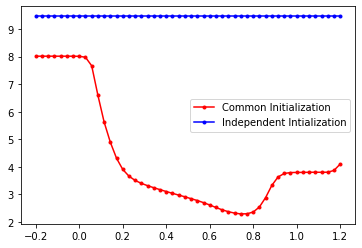

In [ ]:
def build_model(weights):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(200),
        tf.keras.layers.Dense(10)
    ])
    model.build((None, 784))
    model.set_weights(weights)

    return model

def build_weights():
    W1 = tf.random.normal([784, 200], stddev=0.1)
    b1 = tf.random.normal([200], stddev=0.1)
    W2 = tf.random.normal([200, 10], stddev=0.1)
    b2 = tf.random.normal([10], stddev=0.1)

    return [W1, b1, W2, b2]

def loss_surface_demo():
    weight1 = build_weights()
    weight2 = build_weights()

    theta = np.linspace(-.2, 1.2, 50)

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

    r = np.random.choice(60000, 1200)
    ind1 = r[:600]
    ind2 = r[600:]

    # Common Init
    tf.random.set_seed(1)
    print("***** Common Initialization *****")
    model1 = build_model(weight1)
    model2 = build_model(weight1)

    model1.compile(optimizer=opt, loss=loss_function)
    model2.compile(optimizer=opt, loss=loss_function)

    model1.fit(x_train[ind1], y_train[ind1], batch_size=50, epochs=20, verbose=0)
    model2.fit(x_train[ind2], y_train[ind2], batch_size=50, epochs=20, verbose=0)

    common = []
    for t in theta:
        w1 = [t * w for w in model1.get_weights()]
        w2 = [(1-t) * w for w in model2.get_weights()]
     
        weights = [w_1 + w_2 for w_1, w_2 in zip(w1, w2)]
        model = build_model(weights)

        logits = model(x_train)
        loss = loss_function(y_train, logits)
        common.append(loss)    
    
    # Different Init
    tf.random.set_seed(None)
    print("***** Independent Initialization *****")
    model1 = build_model(weight1)
    model2 = build_model(weight2)

    model1.compile(optimizer=opt, loss=loss_function)
    model2.compile(optimizer=opt, loss=loss_function)

    model1.fit(x_train[ind1], y_train[ind1], batch_size=50, epochs=20, verbose=0)
    model2.fit(x_train[ind2], y_train[ind2], batch_size=50, epochs=20, verbose=0)

    diff = []
    for t in theta:
        w1 = [t * w for w in model1.get_weights()]
        w2 = [(1-t) * w for w in model1.get_weights()]
        
        weights = [w_1 + w_2 for w_1, w_2 in zip(w1, w2)]
        model = build_model(weights)

        logits = model(x_train)
        loss = loss_function(y_train, logits)
        diff.append(loss)
    
    # Plot
    plt.figure(1)
    plt.plot(theta, common, 'r.-', label='Common Initialization')
    plt.plot(theta, diff, 'b.-', label='Independent Intialization')
    plt.legend()
    plt.show()

loss_surface_demo()

In [ ]:
def main():
    # Create Server and Update
    server = Server(clients)
    server.update()

if __name__ == '__main__':
    main()

ROUND 1 / 25 NUM SAMPLES : 29
ROUND 1 / 25 UPDATE ACCURACY : 71.72 %
ROUND 2 / 25 NUM SAMPLES : 94
ROUND 2 / 25 UPDATE ACCURACY : 90.36 %
ROUND 3 / 25 NUM SAMPLES : 94
ROUND 3 / 25 UPDATE ACCURACY : 93.89 %
ROUND 4 / 25 NUM SAMPLES : 100
ROUND 4 / 25 UPDATE ACCURACY : 95.89 %
ROUND 5 / 25 NUM SAMPLES : 59
ROUND 5 / 25 UPDATE ACCURACY : 96.86 %
ROUND 6 / 25 NUM SAMPLES : 100
ROUND 6 / 25 UPDATE ACCURACY : 96.88 %
ROUND 7 / 25 NUM SAMPLES : 51
ROUND 7 / 25 UPDATE ACCURACY : 97.78 %
ROUND 8 / 25 NUM SAMPLES : 75
ROUND 8 / 25 UPDATE ACCURACY : 97.81 %
ROUND 9 / 25 NUM SAMPLES : 60
ROUND 9 / 25 UPDATE ACCURACY : 97.82 %
ROUND 10 / 25 NUM SAMPLES : 95
ROUND 10 / 25 UPDATE ACCURACY : 97.82 %
ROUND 11 / 25 NUM SAMPLES : 56
ROUND 11 / 25 UPDATE ACCURACY : 97.80 %
ROUND 12 / 25 NUM SAMPLES : 100
ROUND 12 / 25 UPDATE ACCURACY : 97.80 %
ROUND 13 / 25 NUM SAMPLES : 4
ROUND 13 / 25 UPDATE ACCURACY : 97.80 %
ROUND 14 / 25 NUM SAMPLES : 24
ROUND 14 / 25 UPDATE ACCURACY : 97.82 %
ROUND 15 / 25 NUM SAMP